<a href="https://colab.research.google.com/github/IsaacGordin/MohonkForestData/blob/main/TreeDat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

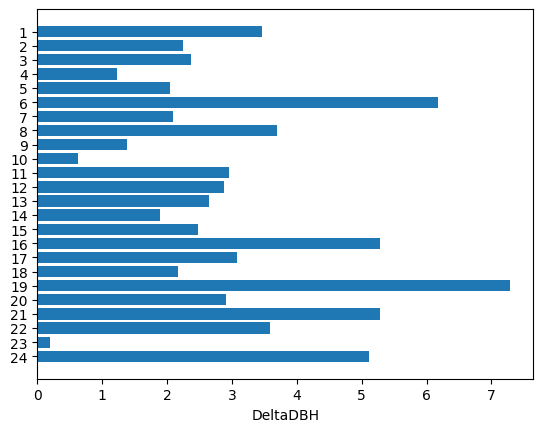

In [2]:
'''
Isaac Gordin
4/1/2024
This code will be for analyzing the overstory tree data
'''


#Import libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import defaultdict
import statistics
import seaborn

#import data
url = 'https://raw.githubusercontent.com/IsaacGordin/MohonkForestData/main/TreeDat.csv'
treedat = pd.read_csv(url)
fc = math.pi/(4*144) # value is used to convert diameter(inches) to area(feet), Forester's Constant
plotAreaSquareMeters = 225 #Value given to me by Megan Napoli, 15x15 meter plots
plotAreaAcres = plotAreaSquareMeters/4047

#This function will add: dbh in inches, basal area in square feet, and expansion factor to the dataframe
#The expansion factor is used to create a trees per acre value. The plots are ~ 1/18 acres, so one tree per plot represents 18 trees per acre
def colAdd(df):
  df['DBHInches'] = df['DBH']/2.54
  df['ba'] = (df['DBHInches']**2)*fc
  df['ef'] = 1/plotAreaAcres
  return df
treedat = colAdd(treedat)

#This function returns a dataframe of data by plot. The data includes the DBH/ba sum and avg, tree count, and forest type, and trees per acre.
def plotAverages(df, year):
  if(year == 2018):
    df = df[df['Year'] == 2018]
  else:
    df = df[df['Year'] > 2018]
  plotCount = df['Plot'].nunique()
  plotList = list(range(1,plotCount+1)) #Create empty lists to populate with data
  treeCount = [0]*plotCount
  DBHSum = [0]*plotCount
  QMD = [0]*plotCount
  baSum = [0]*plotCount
  DBHAvg = [0]*plotCount
  baAvg = [0]*plotCount
  baa = [0]*plotCount
  tpa = [0]*plotCount
  forestType = ['']*plotCount
  for index, row in df.iterrows(): #Iterate over dataset
    if(math.isnan(row['DBH']) | math.isnan(row['Tree_#'])): #Check that the tree is there
      continue
    DBHSum[row['Plot']-1] += row['DBHInches'] #Increment values
    baSum[row['Plot']-1] += row['ba']
    treeCount[row['Plot']-1] += 1
    forestType[row['Plot']-1] = row['Plot.Type']
  for i in plotList:
    DBHAvg[i-1] = DBHSum[i-1]/treeCount[i-1] #Average values
    baAvg[i-1] = baSum[i-1]/treeCount[i-1]
    QMD[i-1] = math.sqrt(baAvg[i-1]/fc)
    baa[i-1] = baSum[i-1] * (1/plotAreaAcres)
    tpa[i-1] = treeCount[i-1] * (1/plotAreaAcres)

  returnTable = pd.DataFrame({'Plot': plotList, 'TreeCount': treeCount, 'DBHSum': DBHSum, 'DBHAvg': DBHAvg, 'QMD': QMD,
                              'baSum': baSum, 'baAvg': baAvg,  'baa': baa, 'tpa': tpa, 'ForestType': forestType})
  return returnTable


#This function will show the change in diameter sum from the plots that were established in 2018 and resampled in 2022
def plotDelta(dataFrame):
  plotCount = dataFrame[dataFrame['Year']==2018]['Plot'].nunique()#Count of plots sampled in 2018
  dat2018 = plotAverages(dataFrame, 2018)
  dat2022 = plotAverages(dataFrame, 2020)
  dat2022 = dat2022[dat2022['Plot'] <= plotCount]
  deltaArr = [0]*plotCount
  for i in range(len(dat2018['DBHSum'])):
    deltaArr[i] = dat2022['DBHSum'][i] - dat2018['DBHSum'][i]
  return deltaArr

#This method creates a new data frame of trees that were sampled in 2018 and 2022 where the diameters are valid and accurate
#The checks we do include, does tree exist, does diameter data exist for both years, if diameter decreases by a large amount, if tree is dead, discard.
def deltaValid(df):
  plotCount = df[df['Year']==2018]['Plot'].nunique()
  plot, treenum, dbh18List, dbh22List, deltaList, species18List, species22List, status18List, status22List, forestTypeList = [],[],[],[],[],[],[],[],[],[]
  for i in range(1,(plotCount+1),1): #I represents the plot number
    for j in range(1, (len(df[df['Plot'] == i])+1),1): #J represents the tree number
      row18 = df[(df['Plot'] == i) & (df['Tree_#'] == j) & (df['Year'] == 2018)] #Unique row val
      row22 = df[(df['Plot'] == i) & (df['Tree_#'] == j) & (df['Year'] == 2022)]
      if(row18.empty | row22.empty): #.empty checks if data exists for the tree coordinates. ie, tree added in 22 doesn't exist in 18
        continue
      dbh18 = row18['DBHInches']
      dbh22 = row22['DBHInches']
      species18 = row18['Species'].values[0] #gets rid of all the noise, ie, 577 White pine Name: Species, dtype: object --> White Pine
      species22 = row22['Species'].values[0]
      status18 = str(row18['Status'].values[0])
      status22 = str(row22['Status'].values[0])
      forestType = row18['Plot.Type'].values[0]
      if(status18.__contains__('D') | status22.__contains__('D')): #This catches for if the tree is dead. Can't measure growth if tree died
        continue
      if(math.isnan(dbh18) | math.isnan(dbh22)):
        continue
      dbh18 = float(dbh18) # see .values[0], same purpose
      dbh22 = float(dbh22)
      decreasePercentage = .9
      delta = dbh22 - dbh18
      if((decreasePercentage*dbh18) > dbh22): #If the diameter decreased and it decreased by more than 10% of original diameter
        continue
      plot.append(i), treenum.append(j), dbh18List.append(dbh18), dbh22List.append(dbh22), deltaList.append(delta), species18List.append(species18)
      species22List.append(species22), status18List.append(status18), status22List.append(status22), forestTypeList.append(forestType)
  cleanedDat = pd.DataFrame({'Plot': plot, 'TreeNum': treenum, 'DBH18': dbh18List, 'DBH22': dbh22List, 'DeltaDBH': deltaList,
                'Species': species18List, 'Species22': species22List, 'Status18': status18List, 'Status22': status22List, 'ForestType': forestTypeList})
  return cleanedDat

#This function returns a dataframe of clean data from 21/22. Clean data is considered to have a non na number for plot, treenum, and DBH
def cleanModernDataTable(df):
  df = df[df['Year'] > 2018]
  plot, treenum, dbhList, baList, efList, speciesList, statusList, forestTypeList = [],[],[],[],[],[],[],[]
  for index, row in df.iterrows():
    if((math.isnan(row['Plot'])) | (math.isnan(row['Tree_#'])) | (math.isnan(row['DBH']))):
      continue
    plot.append(row['Plot'])
    treenum.append(row['Tree_#'])
    dbhList.append(row['DBHInches'])
    baList.append(row['ba'])
    efList.append(row['ef'])
    speciesList.append(row['Species'])
    statusList.append(row['Status'])
    forestTypeList.append(row['Plot.Type'])
    returnTable = pd.DataFrame({'Plot': plot, 'TreeNum': treenum, 'DBHInches': dbhList, 'ba': baList, 'ef': efList,
                'Species': speciesList, 'Status': statusList,'ForestType': forestTypeList})
  return returnTable

#This function will take a cleaned dataset and show measurement by type.
def plotter(df, xAxis, xAction, yAxis):
  dataList = list(set(df[yAxis])) #Set of the yAxis parameters become the keys
  SumDict = dict.fromkeys(dataList,0) #The 0 initializes the list at 0
  CountDict = dict.fromkeys(dataList,0)
  AvgDict = dict.fromkeys(dataList,0)
  for index, row in df.iterrows():
    yVal = row[yAxis] #The will represent the individual value of the ie, species
    xSum = float(row[xAxis])
    SumDict[yVal] += xSum #Increment the DBH sum,
    CountDict[yVal] += 1 #Increment the count

  for key in SumDict: #Create the averages
    AvgDict[key] = SumDict[key] / CountDict[key]

  cd = defaultdict(list) #This combines the lists
  for d in (SumDict, CountDict, AvgDict):
    for key, value in d.items():
      cd[key].append(value)

  values = [elem[xAction] for elem in cd.values()] #The xAxis parameter is used here to determine sum, count, or average

  fig, ax = plt.subplots()
  y_pos = np.arange(len(cd.keys()))
  ax.barh(y_pos, values, align='center')
  ax.set_yticks(y_pos, labels=cd.keys())
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(xAxis)
  ax.set_title('')


modDat = cleanModernDataTable(treedat) #Modern(21/22) dataframe
changeDat = deltaValid(treedat) #dataframe of values from 2018-2022 that show forest change
plotter(changeDat, 'DeltaDBH', 0, 'Plot')


hemlock = modDat[(modDat['ForestType'] == 'Hemlock') | (modDat['ForestType'] == 'Hemlock-BB') | (modDat['ForestType'] == 'HemlockHardwood-BB')]
ash = modDat[modDat['ForestType'] == 'Ash']
pp = modDat[modDat['ForestType'] == 'PitchPine-BB']
chest = modDat[(modDat['ForestType'] == 'ChestnutOak-BB') | (modDat['ForestType'] == 'Burn')] #Burn forest type was burned 10 years ago, still in chestnut oak predominant forest
oakhick = modDat[modDat['ForestType'] == 'OakHickory-BB']



